<a href="https://colab.research.google.com/github/Jalalbaim/Auto-Encoder/blob/main/autoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoEncoder
Baim Mohamed

In [1]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:01<00:00, 16187141.71it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 262816.29it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5101125.17it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6457020.63it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [5]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()

        self.flatten = nn.Flatten()

        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.Tanh())


        #decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim))

    def forward(self, x):
        x = self.flatten(x)
        x = self.encoder(x)
        x = self.decoder(x)
        return x


autoencoder = Autoencoder(28*28, 2).to(device)
print(autoencoder)


Autoencoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=2, bias=True)
    (1): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=784, bias=True)
  )
)


In [6]:
import torch.nn.functional as F

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(autoencoder.parameters(), lr=1e-3)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)
        X = X.view(-1, 28*28)

        pred = model(X)
        loss = loss_fn(pred, X)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [8]:
def test(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            X = X.view(-1, 28*28)
            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    num_batches = len(dataloader)
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")


In [9]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, autoencoder, loss_fn, optimizer)
    test(test_dataloader, autoencoder, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.395551  [    0/60000]
loss: 0.339343  [ 6400/60000]
loss: 0.374848  [12800/60000]
loss: 0.338996  [19200/60000]
loss: 0.381913  [25600/60000]
loss: 0.378459  [32000/60000]
loss: 0.344869  [38400/60000]
loss: 0.357807  [44800/60000]
loss: 0.373889  [51200/60000]
loss: 0.360178  [57600/60000]
Avg loss: 0.370419 

Epoch 2
-------------------------------
loss: 0.373715  [    0/60000]
loss: 0.336664  [ 6400/60000]
loss: 0.372125  [12800/60000]
loss: 0.336837  [19200/60000]
loss: 0.379458  [25600/60000]
loss: 0.376219  [32000/60000]
loss: 0.343284  [38400/60000]
loss: 0.355735  [44800/60000]
loss: 0.371887  [51200/60000]
loss: 0.358338  [57600/60000]
Avg loss: 0.368550 

Epoch 3
-------------------------------
loss: 0.371942  [    0/60000]
loss: 0.335148  [ 6400/60000]
loss: 0.370400  [12800/60000]
loss: 0.335199  [19200/60000]
loss: 0.377722  [25600/60000]
loss: 0.374463  [32000/60000]
loss: 0.341789  [38400/60000]
loss: 0.354071  [44800/60000

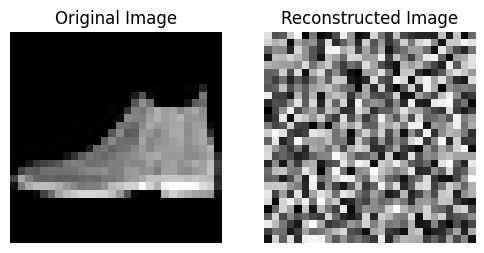

In [17]:
autoencoder.eval()

image = test_data[0][0].unsqueeze(0).to(device)

image_flattened = image.view(-1, 28*28)

with torch.no_grad():
    output = autoencoder(image_flattened)
    output = output.view(28, 28)

figure, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].imshow(image[0][0].cpu(), cmap='gray')
ax[0].title.set_text('Original Image')
ax[0].axis('off')


ax[1].imshow(output.cpu(), cmap='gray')
ax[1].title.set_text('Reconstructed Image')
ax[1].axis('off')

plt.show()